## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 35.3 MB/s 
     |████████████████████████████████| 212 kB 75.3 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = dataset['train']
val = dataset['validation']
test =  dataset['test']

In [11]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels
            

In [12]:
tweets, labels = get_tweet(train)

In [13]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [58]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [59]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [60]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [61]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

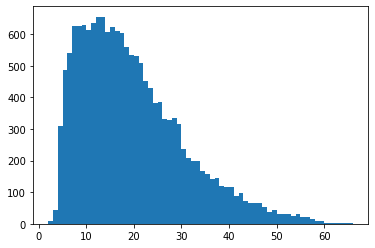

In [62]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [63]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [64]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post' , padding='post' , maxlen = maxlen)
  return padded

In [65]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [66]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [67]:
classes = set(labels)
print(classes)

{'anger', 'surprise', 'fear', 'joy', 'love', 'sadness'}


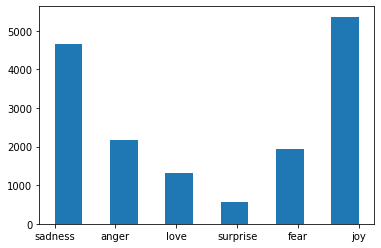

In [68]:
plt.hist(labels, bins=11)
plt.show()

There is a class imbalance problem. But still it wont affect our project much, so we are going ahead with this.

In [69]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [70]:
class_to_index

{'anger': 0, 'fear': 2, 'joy': 3, 'love': 4, 'sadness': 5, 'surprise': 1}

In [71]:
index_to_class

{0: 'anger', 1: 'surprise', 2: 'fear', 3: 'joy', 4: 'love', 5: 'sadness'}

In [72]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [73]:
train_labels = names_to_ids(labels)
print(train_labels[0])

5


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [74]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences =True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [75]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_5 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [76]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [77]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

In [78]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 12s 16ms/step - loss: 1.3070 - accuracy: 0.4952 - val_loss: 0.7779 - val_accuracy: 0.7065
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.5522 - accuracy: 0.8073 - val_loss: 0.5517 - val_accuracy: 0.8260
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3326 - accuracy: 0.8956 - val_loss: 0.4580 - val_accuracy: 0.8600
Epoch 4/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2014 - accuracy: 0.9386 - val_loss: 0.4519 - val_accuracy: 0.8605
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1577 - accuracy: 0.9526 - val_loss: 0.4126 - val_accuracy: 0.8780
Epoch 6/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1300 - accuracy: 0.9607 - val_loss: 0.4600 - val_accuracy: 0.8780
Epoch 7/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1093 - accuracy: 0.9663 - val_loss: 0.4395 - val_accuracy: 0.883

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

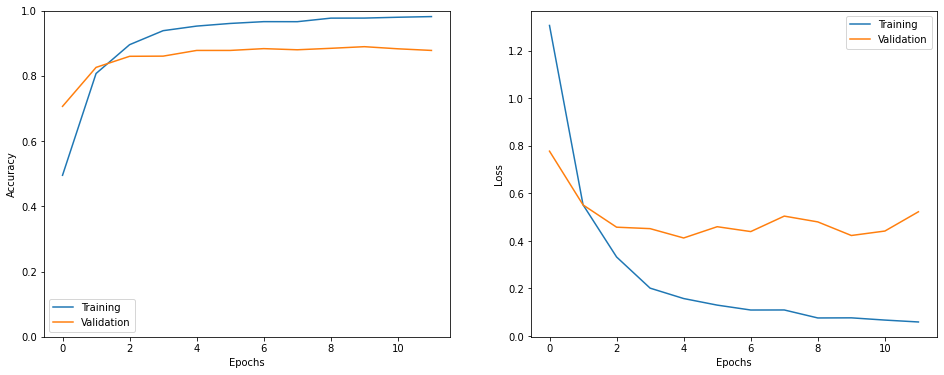

In [79]:
show_history(h)

In [80]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [82]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4984 - accuracy: 0.8720


In [84]:
i =  random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:' , pred_class)

Sentence: i replied feeling strange at giving the orders
Emotion: surprise
Predicted Emotion: fear


In [90]:
preds = np.argmax(model.predict(test_seq), axis=-1)

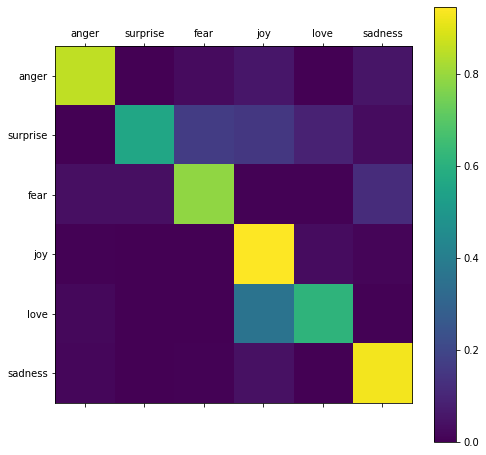

In [91]:
show_confusion_matrix(test_labels, preds, list(classes))

So our models is doing pretty well predictions with every emotions except it gets confused between "joy-love" and "fear-surprise" sometimes. This is due to the class imbalance in our dataset.